# Import Modules

In [1]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from scipy.io import loadmat
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dpc_algorithm import DPCSolver
import os
import glob
import cv2

# Load DPC Measurements

In [2]:
# data_path  = "../sample_data/"         #INSERT YOUR DATA PATH HERE
# data_name  = "dataset_DPC_MCF10A.mat"  #HERE THE MATFILE IS USED TO STORE RAW DPC IMAGES
# dpc_images = loadmat(data_path+data_name)["IDPC"]

# dpc_images.shape

In [3]:

data_path  = "../private_data/standard_target_data_2_axis/350/"       
images_path  = sorted(glob.glob(os.path.join(data_path, "*.bmp")))
# print(images_path)

dpc_images = []
for i in range(len(images_path)):
    img = cv2.imread(images_path[i], cv2.IMREAD_GRAYSCALE)
    img = np.expand_dims(img, 0)
    dpc_images.append(img)
    
dpc_images = np.concatenate(dpc_images,0)
print(dpc_images.shape)

(4, 1944, 2592)


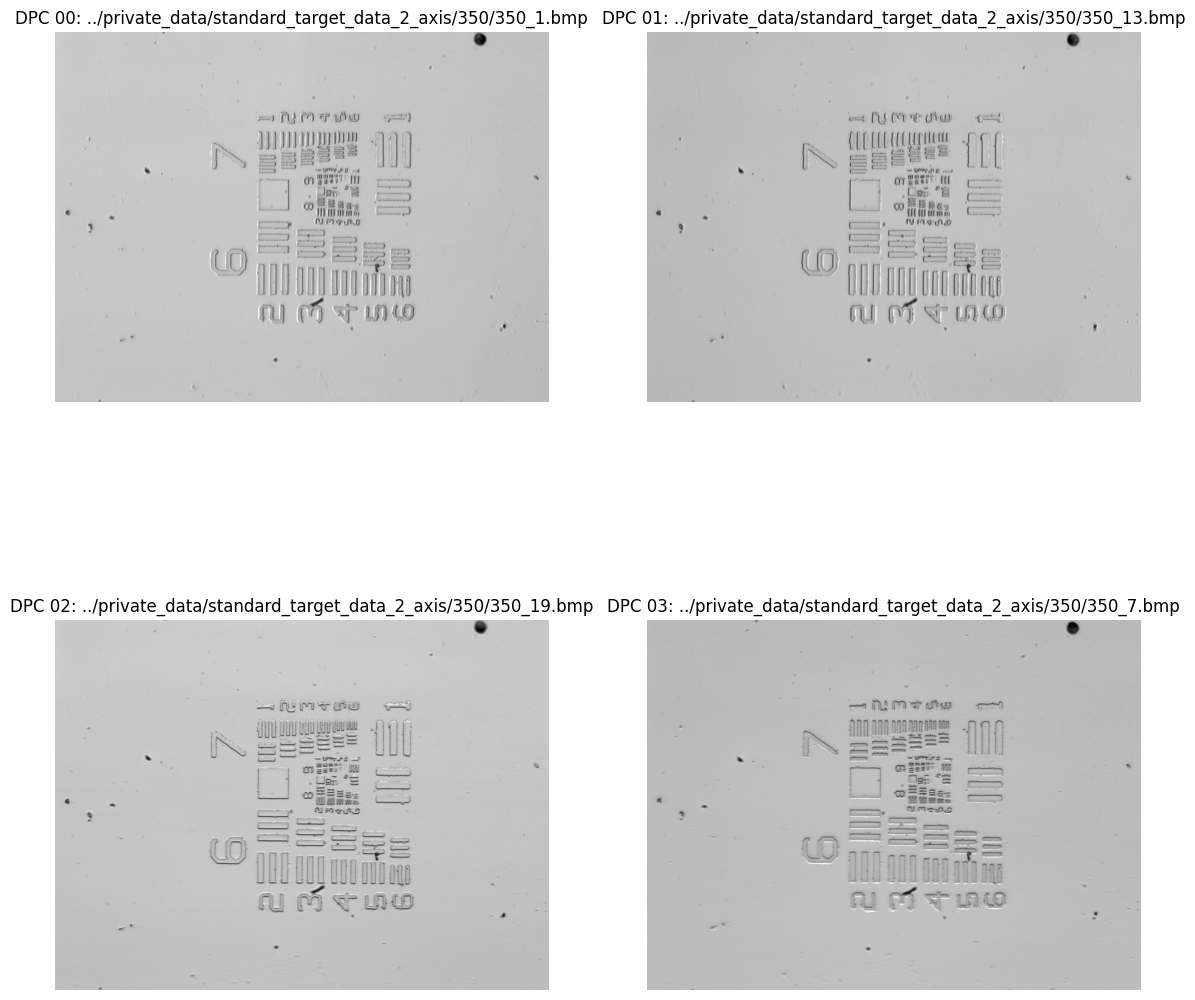

In [4]:
#plot first set of measured DPC measurements
f, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(14, 14))
for plot_index in range(4):
    plot_row = plot_index//2
    plot_col = np.mod(plot_index, 2)
    ax[plot_row, plot_col].imshow(dpc_images[plot_index], cmap="gray",\
                                  extent=[0, dpc_images[0].shape[-1], 0, dpc_images[0].shape[-2]])
    ax[plot_row, plot_col].axis("off")
    ax[plot_row, plot_col].set_title(f"DPC {plot_index:02d}: {images_path[plot_index]}")

# Set System Parameters

In [5]:
wavelength     =  0.532 #micron
mag            =   10.0
na             =   0.3 #numerical aperture
na_in          =    0.0
pixel_size_cam =    2.2 #pixel size of camera
dpc_num        =      4 #number of DPC images captured for each absorption and phase frame
pixel_size     = pixel_size_cam/mag
rotation       = [90, 0, 270, 180] #degree

# DPC Absorption and Phase Retrieval

## Initialize DPC Solver

In [6]:
dpc_solver_obj = DPCSolver(dpc_images, wavelength, na, na_in, pixel_size, rotation, dpc_num=dpc_num)

## Visualize Source Patterns 

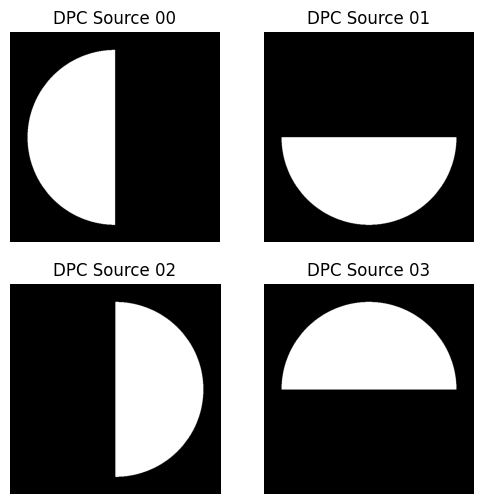

In [7]:
#plot the sources
max_na_x = max(dpc_solver_obj.fxlin.real*dpc_solver_obj.wavelength/dpc_solver_obj.na)
min_na_x = min(dpc_solver_obj.fxlin.real*dpc_solver_obj.wavelength/dpc_solver_obj.na)
max_na_y = max(dpc_solver_obj.fylin.real*dpc_solver_obj.wavelength/dpc_solver_obj.na)
min_na_y = min(dpc_solver_obj.fylin.real*dpc_solver_obj.wavelength/dpc_solver_obj.na)
f, ax  = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6))
for plot_index, source in enumerate(list(dpc_solver_obj.source)):
    plot_row = plot_index//2
    plot_col = np.mod(plot_index, 2)
    ax[plot_row, plot_col].imshow(np.fft.fftshift(dpc_solver_obj.source[plot_index]),\
                                  cmap='gray', clim=(0,1), extent=[min_na_x, max_na_x, min_na_y, max_na_y])
    ax[plot_row, plot_col].axis("off")
    ax[plot_row, plot_col].set_title("DPC Source {:02d}".format(plot_index))
    ax[plot_row, plot_col].set_xlim(-1.2, 1.2)
    ax[plot_row, plot_col].set_ylim(-1.2, 1.2)
    ax[plot_row, plot_col].set_aspect(1)

## Visualize Weak Object Transfer Functions

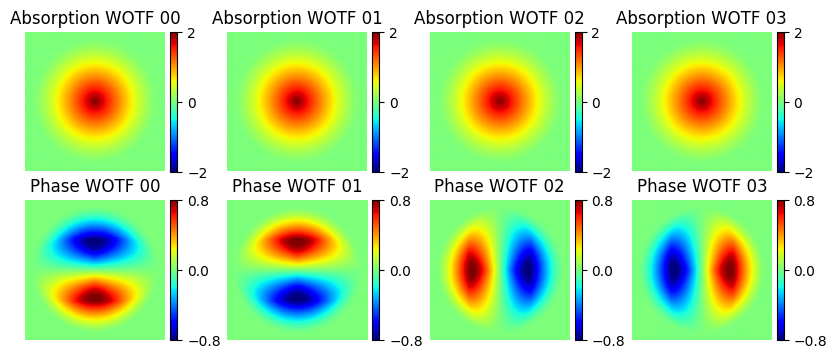

In [7]:
#plot the transfer functions
f, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize = (10, 4))
for plot_index in range(ax.size):
    plot_row = plot_index//4
    plot_col = np.mod(plot_index, 4)
    divider  = make_axes_locatable(ax[plot_row, plot_col])
    cax      = divider.append_axes("right", size="5%", pad=0.05)
    if plot_row == 0:
        plot = ax[plot_row, plot_col].imshow(np.fft.fftshift(dpc_solver_obj.Hu[plot_col].real), cmap='jet',\
                                             extent=[min_na_x, max_na_x, min_na_y, max_na_y], clim=[-2., 2.])
        ax[plot_row, plot_col].set_title("Absorption WOTF {:02d}".format(plot_col))
        plt.colorbar(plot, cax=cax, ticks=[-2., 0, 2.])
    else:
        plot = ax[plot_row, plot_col].imshow(np.fft.fftshift(dpc_solver_obj.Hp[plot_col].imag), cmap='jet',\
                                             extent=[min_na_x, max_na_x, min_na_y, max_na_y], clim=[-.8, .8])
        ax[plot_row, plot_col].set_title("Phase WOTF {:02d}".format(plot_col))
        plt.colorbar(plot, cax=cax, ticks=[-.8, 0, .8])
    ax[plot_row, plot_col].set_xlim(-2.2, 2.2)
    ax[plot_row, plot_col].set_ylim(-2.2, 2.2)
    ax[plot_row, plot_col].axis("off")
    ax[plot_row, plot_col].set_aspect(1)

## Solve DPC Deconvoltion Problems

### Tikhonov Regularization

In [8]:
#parameters for Tikhonov regurlarization [u:absorption, p:phase] ((need to tune this based on SNR)
dpc_solver_obj.setRegularizationParameters(reg_u = 1e-1, reg_p = 5e-3)
dpc_result = dpc_solver_obj.solve(method="Tikhonov")

Text(0.5, 1.0, 'Phase')

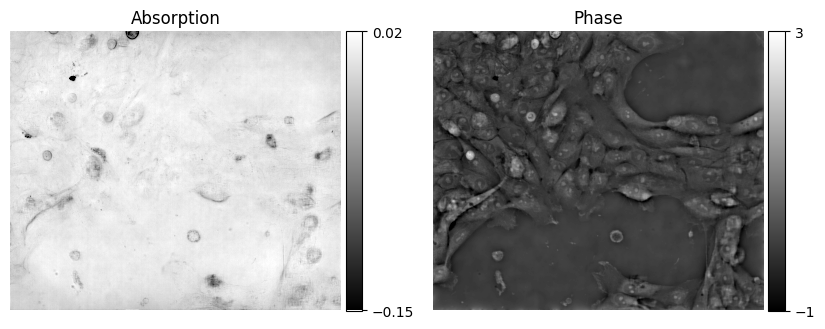

In [9]:
_, axes  = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)
divider  = make_axes_locatable(axes[0])
cax_1    = divider.append_axes("right", size="5%", pad=0.05)
plot     = axes[0].imshow(dpc_result[0].real, clim=[-0.15, 0.02], cmap="gray", extent=[0, dpc_result[0].shape[-1], 0, dpc_result[0].shape[-2]])
axes[0].axis("off")
plt.colorbar(plot, cax=cax_1, ticks=[-0.15, 0.02])
axes[0].set_title("Absorption")
divider  = make_axes_locatable(axes[1])
cax_2    = divider.append_axes("right", size="5%", pad=0.05)
plot     = axes[1].imshow(dpc_result[0].imag, clim=[-1.0, 3.0], cmap="gray", extent=[0, dpc_result[0].shape[-1], 0, dpc_result[0].shape[-2]])
axes[1].axis("off")
plt.colorbar(plot, cax=cax_2, ticks=[-1.0, 3.0])
axes[1].set_title("Phase")

### TV Regularization

In [10]:
#parameters for TV regurlarization [u:absorption, p:phase] ((need to tune this based on your sample)
dpc_solver_obj.setRegularizationParameters(reg_u = 1e-1, reg_p = 5e-3, tau_u = 1.0, tau_p = 1.0, rho = 1.0)
dpc_result = dpc_solver_obj.solve(method="TV", tv_order=3, tv_max_iter=10)

Text(0.5, 1.0, 'Phase')

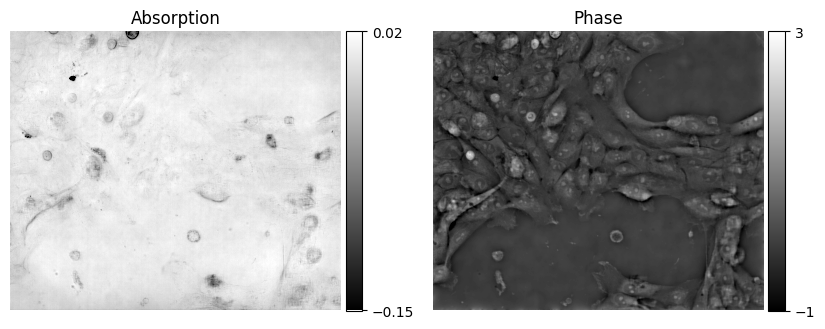

In [11]:
_, axes  = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)
divider  = make_axes_locatable(axes[0])
cax_1    = divider.append_axes("right", size="5%", pad=0.05)
plot     = axes[0].imshow(dpc_result[0].real, clim=[-0.15, 0.02], cmap="gray", extent=[0, dpc_result[0].shape[-1], 0, dpc_result[0].shape[-2]])
axes[0].axis("off")
plt.colorbar(plot, cax=cax_1, ticks=[-0.15, 0.02])
axes[0].set_title("Absorption")
divider  = make_axes_locatable(axes[1])
cax_2    = divider.append_axes("right", size="5%", pad=0.05)
plot     = axes[1].imshow(dpc_result[0].imag, clim=[-1.0, 3.0], cmap="gray", extent=[0, dpc_result[0].shape[-1], 0, dpc_result[0].shape[-2]])
axes[1].axis("off")
plt.colorbar(plot, cax=cax_2, ticks=[-1.0, 3.0])
axes[1].set_title("Phase")